In [1]:
# Importing Libraries:

import pandas as pd
import numpy as np
from scipy.stats import shapiro

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import KFold, cross_validate
from sklearn.base import clone
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [2]:
# Importing data:

df_raw = pd.read_csv("KAG_energydata_complete.csv")

In [3]:
# Creating a copy of the dataset:

df = df_raw.copy()

In [4]:
print(f"Shape: {df.shape}")

Shape: (19735, 29)


In [5]:
# Looking at the first five lines: 

df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


## 1) Data Munging

#### 1.1) Data Cleaning

First let's see if there are missing data in the dataset.

In [6]:
# Looking for missing data:

df.isna().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

Looking for wrong variable type

In [7]:
# Information about data types:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [8]:
# Changing date's type to datetime:

df['date'] = pd.to_datetime(df['date'])
df.dtypes

date           datetime64[ns]
Appliances              int64
lights                  int64
T1                    float64
RH_1                  float64
T2                    float64
RH_2                  float64
T3                    float64
RH_3                  float64
T4                    float64
RH_4                  float64
T5                    float64
RH_5                  float64
T6                    float64
RH_6                  float64
T7                    float64
RH_7                  float64
T8                    float64
RH_8                  float64
T9                    float64
RH_9                  float64
T_out                 float64
Press_mm_hg           float64
RH_out                float64
Windspeed             float64
Visibility            float64
Tdewpoint             float64
rv1                   float64
rv2                   float64
dtype: object

In [9]:
# Setting date as the index

df.set_index('date', inplace=True)

#### 1.2) Exploratory Data Analisys

In [10]:
# Separating columns

temperature_column = [i for i in df.columns if "T" in i]
humidity_column = [i for i in df.columns if "RH" in i]
other = [i for i in df.columns if ("T" not in i)&("RH" not in i)]

In [11]:
# Humidity statistics:

df[humidity_column].describe()

,RH_1,RH_2,RH_3,RH_4,RH_5,RH_6,RH_7,RH_8,RH_9,RH_out
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,40.259739,40.420420,39.242500,39.026904,50.949283,54.609083,35.388200,42.936165,41.552401,79.750418
std,3.979299,4.069813,3.254576,4.341321,9.022034,31.149806,5.114208,5.224361,4.151497,14.901088
min,27.023333,20.463333,28.766667,27.660000,29.815000,1.000000,23.200000,29.600000,29.166667,24.000000
25%,37.333333,37.900000,36.900000,35.530000,45.400000,30.025000,31.500000,39.066667,38.500000,70.333333
50%,39.656667,40.500000,38.530000,38.400000,49.090000,55.290000,34.863333,42.375000,40.900000,83.666667
75%,43.066667,43.260000,41.760000,42.156667,53.663333,83.226667,39.000000,46.536000,44.338095,91.666667
max,63.360000,56.026667,50.163333,51.090000,96.321667,99.900000,51.400000,58.780000,53.326667,100.000000


In [12]:
# Temperature statistics:

df[temperature_column].describe()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T_out,Tdewpoint
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,21.686571,20.341219,22.267611,20.855335,19.592106,7.910939,20.267106,22.029107,19.485828,7.411665,3.760707
std,1.606066,2.192974,2.006111,2.042884,1.844623,6.090347,2.109993,1.956162,2.014712,5.317409,4.194648
min,16.790000,16.100000,17.200000,15.100000,15.330000,-6.065000,15.390000,16.306667,14.890000,-5.000000,-6.600000
25%,20.760000,18.790000,20.790000,19.530000,18.277500,3.626667,18.700000,20.790000,18.000000,3.666667,0.900000
50%,21.600000,20.000000,22.100000,20.666667,19.390000,7.300000,20.033333,22.100000,19.390000,6.916667,3.433333
75%,22.600000,21.500000,23.290000,22.100000,20.619643,11.256000,21.600000,23.390000,20.600000,10.408333,6.566667
max,26.260000,29.856667,29.236000,26.200000,25.795000,28.290000,26.000000,27.230000,24.500000,26.100000,15.500000


In [13]:
# Other column statistics:

df[other].describe()

,Appliances,lights,Press_mm_hg,Windspeed,Visibility,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,755.522602,4.039752,38.330834,24.988033,24.988033
std,102.524891,7.935988,7.399441,2.451221,11.794719,14.496634,14.496634
min,10.000000,0.000000,729.300000,0.000000,1.000000,0.005322,0.005322
25%,50.000000,0.000000,750.933333,2.000000,29.000000,12.497889,12.497889
50%,60.000000,0.000000,756.100000,3.666667,40.000000,24.897653,24.897653
75%,100.000000,0.000000,760.933333,5.500000,40.000000,37.583769,37.583769
max,1080.000000,70.000000,772.300000,14.000000,66.000000,49.996530,49.996530


The first, second and third quartiles are 0 for the lights column, which means that most of the information of this column is 0. As we can see below more than 77% of the registers in this column is 0 and so, not relevant to the prediction.

In [14]:
# Counting values of the "lights" column:

df['lights'].value_counts(normalize=True)

lights
0     0.772840
10    0.112085
20    0.082290
30    0.028325
40    0.003902
50    0.000456
70    0.000051
60    0.000051
Name: proportion, dtype: float64

In [15]:
# Dropping the lights column:

df.drop(columns='lights', inplace=True)

Outliers

Looking at the statistics of "other" columns, we can see that there are some outliers in Visibility, Windspeed and Appliance. Let's plot a box plot of each one of those and see the outliers closer.

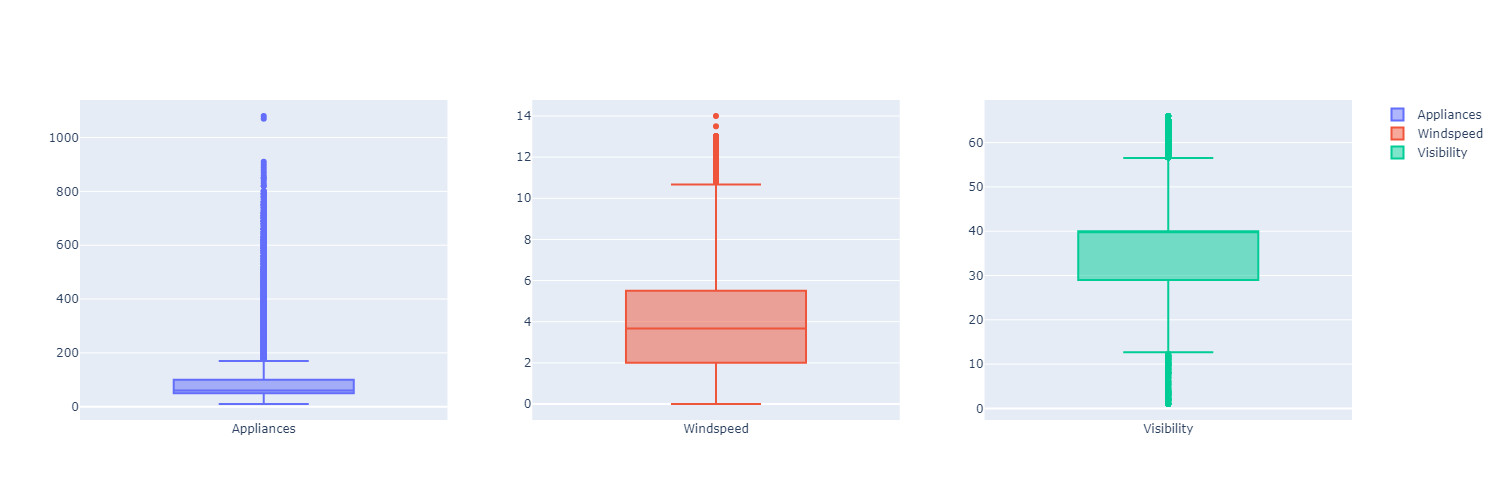

In [16]:
# Using boxplot on Visibility, Appliances and Windspeed to visualize the outliers:

fig_sub = make_subplots(rows=1, cols=3, shared_yaxes=False)

fig_sub.add_trace(

    go.Box(y=df['Appliances'].values,
           name='Appliances'
           ),
    row=1, col=1

)

fig_sub.add_trace(
    go.Box(y=df['Windspeed'].values,
           name='Windspeed'
           ),
    row=1, col=2
)

fig_sub.add_trace(
    go.Box(y=df['Visibility'].values,
           name='Visibility'
           ),
    row=1, col=3
)

fig_sub.show("png",width=1500, height=500)

Distributions

A quick way to have an idea about a varibable distribution is plotting a histogram.

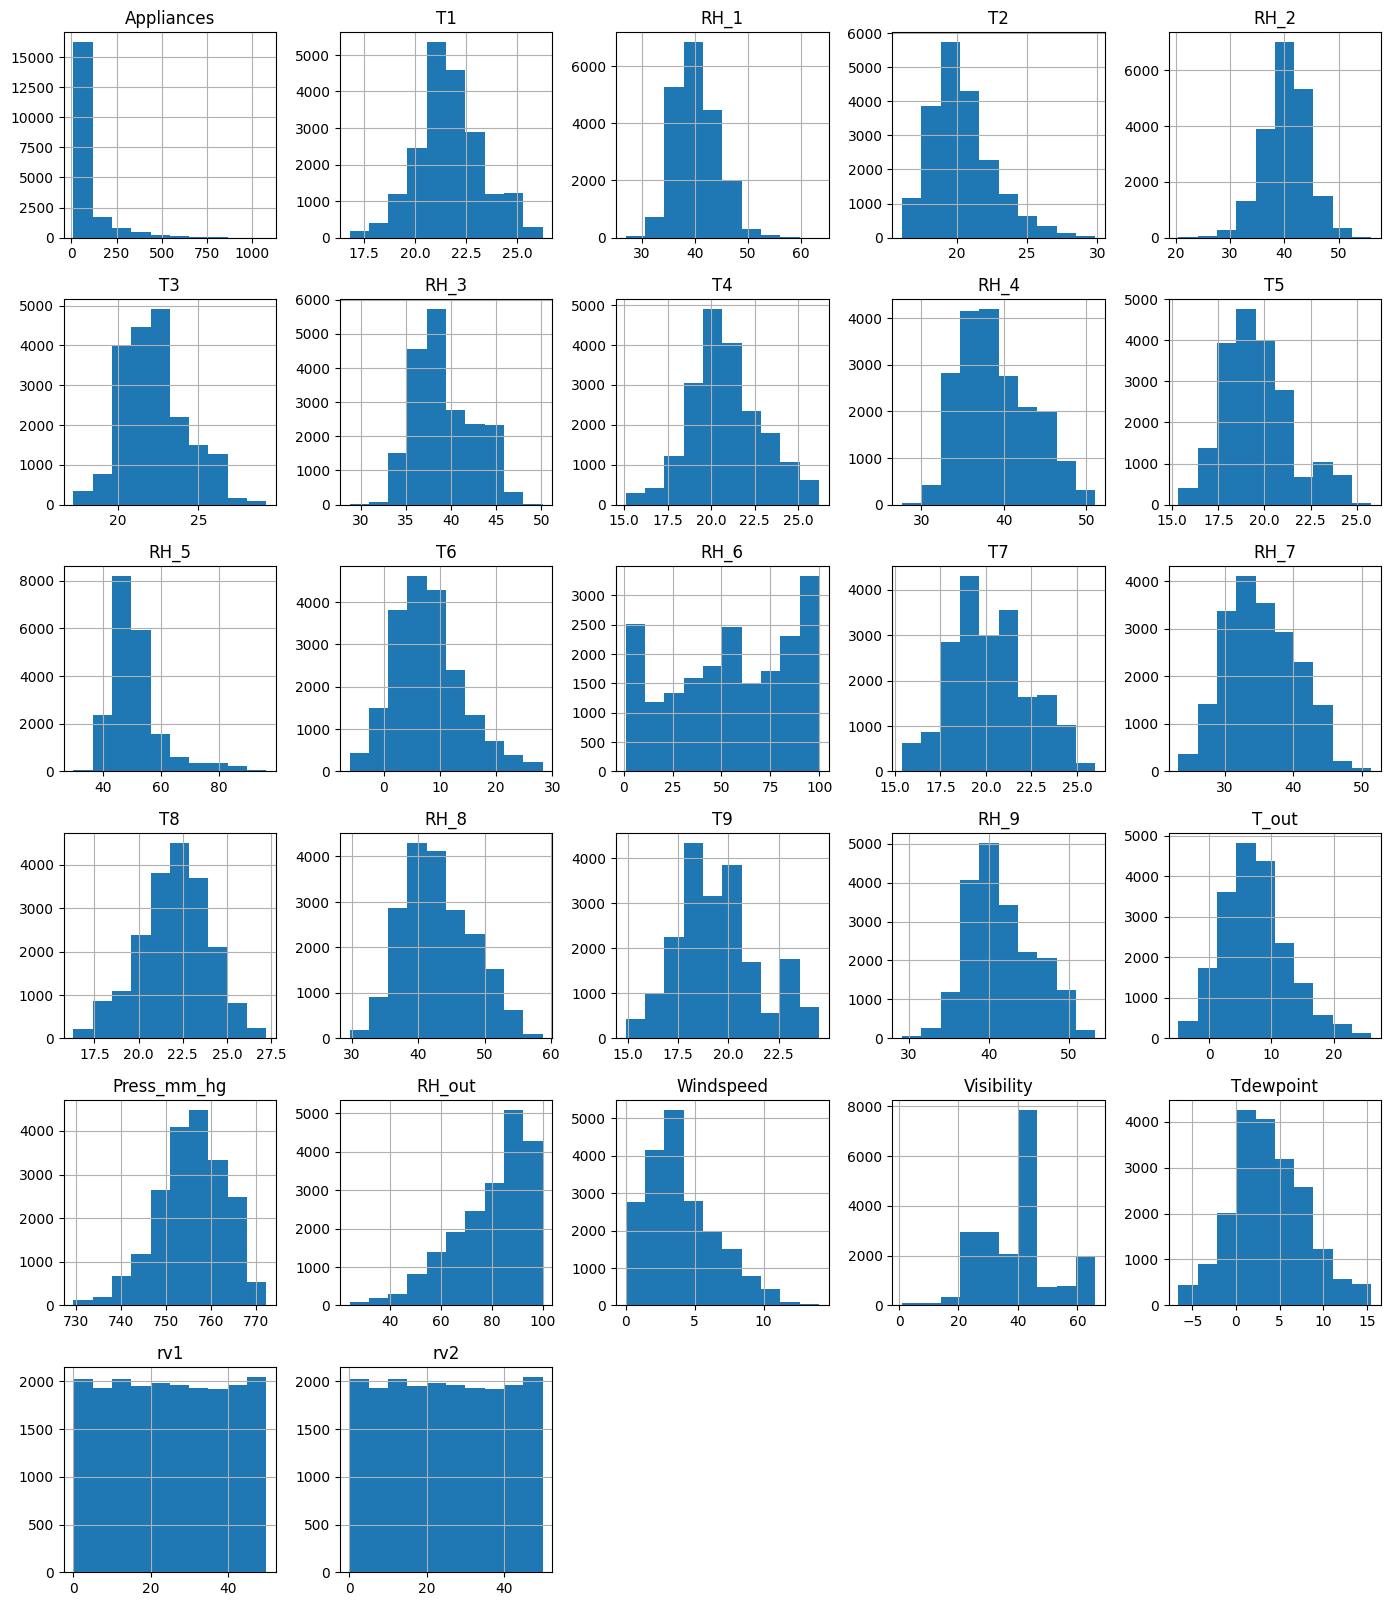

In [17]:
# Visualizing distributions using Histograms:

df.hist(figsize=(17, 20));

We will use a test statistic named Shapiro to evaluate normallity.

Obs:

1 - If p-value is smaller than 0.05, we can not assume a normal distribution.

2 - If p-value is larger than 0.05, we can assume a normal distribution.

3 - For datasets larger than 5000 samples, the p-value will be an approximation.

 

In [18]:
# Using Shapiro test for normallity evaluation:

for c in df.columns:
    w_statisc, p_values = shapiro(df[c])
    print(f'Test for {c}: (statistic={w_statisc}, p-value={p_values})')

Test for Appliances: (statistic=0.5764151811599731, p-value=0.0)
Test for T1: (statistic=0.9914018511772156, p-value=2.131765323498354e-32)
Test for RH_1: (statistic=0.9837190508842468, p-value=5.145567961000728e-42)
Test for T2: (statistic=0.9549049139022827, p-value=0.0)
Test for RH_2: (statistic=0.9937852621078491, p-value=5.234702144451298e-28)
Test for T3: (statistic=0.9819837212562561, p-value=1.1630777253895982e-43)
Test for RH_3: (statistic=0.9622328877449036, p-value=0.0)
Test for T4: (statistic=0.9893089532852173, p-value=1.561547817796443e-35)
Test for RH_4: (statistic=0.9690612554550171, p-value=0.0)
Test for T5: (statistic=0.9709550738334656, p-value=0.0)
Test for RH_5: (statistic=0.8415567278862, p-value=0.0)
Test for T6: (statistic=0.9769178628921509, p-value=0.0)
Test for RH_6: (statistic=0.9380175471305847, p-value=0.0)
Test for T7: (statistic=0.9852830171585083, p-value=2.0875843872278962e-40)
Test for RH_7: (statistic=0.9881099462509155, p-value=4.062436442974527e-37

c:\Users\caios\Documents\DataScience\projects\.conda\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning:

p-value may not be accurate for N > 5000.



Correlations

We will use Pearson's correlarion due to the type and nature of the variables (numeric target and features)

In [19]:
# Function to plot heatmap of correlations:

def plot_correlation(dataframe):
    correlations=dataframe.corr()

    mask =  np.zeros_like(correlations)
    mask[np.triu_indices_from(mask)] = True


    plt.figure(figsize=(27, 10))
    sns.heatmap(correlations, annot=True, mask=mask, cmap="crest");


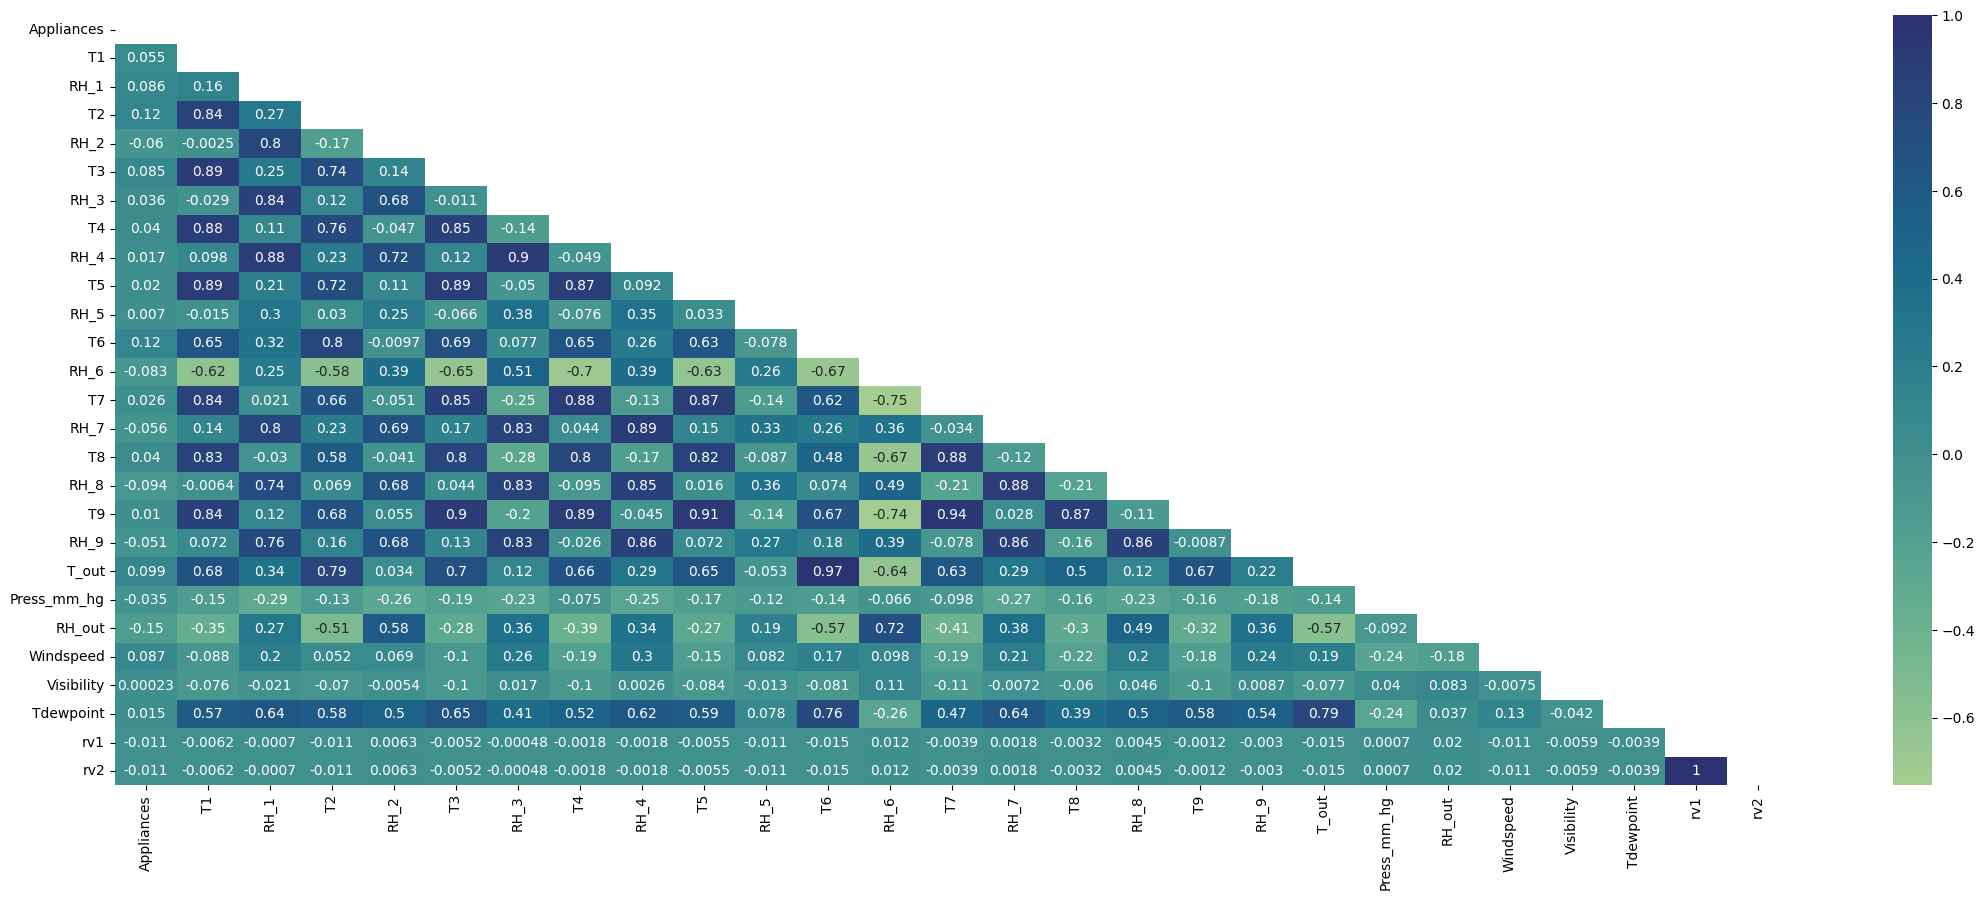

In [20]:
# Plotting a Heatmap with all the correlations:

plot_correlation(df)

Conclusions

1 - As a result of the Shapiro test, no feature follows a normal distribution (p-value less than 0.05).

2 - T6 and T_out are highly correlated(0.97), probably because they both were measured outside the building.

3 - All Temperatures are significant correlated to each other, but T9 has many correlations superior than 0.9 points.

4 - The two random variables are basically the same and their negative correlation with the target is close to 0.

## 2) Preprocessing

In [21]:
# We are going to drop some columns because of their correlation analysis:

features = df.drop(columns=['rv1', 'rv2', 'T_out', 'T9'])

#### 2.1) Feature Engineering

We will transform date column in a binary class feature that will represent weekend(1) and weekdays(0).

In [22]:
# Reset the index:

features_eng = features.reset_index()

In [23]:
# Transfoming date column in a binary class feature:

features_eng['Weekend'] = features_eng['date'].dt.dayofweek

In [24]:
# Printing the dataset

features_eng.head()

,date,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_7,T8,RH_8,RH_9,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Weekend
0,2016-01-11 17:00:00,60,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,41.626667,18.2,48.900000,45.53,733.5,92.0,7.000000,63.000000,5.3,0
1,2016-01-11 17:10:00,60,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,41.560000,18.2,48.863333,45.56,733.6,92.0,6.666667,59.166667,5.2,0
2,2016-01-11 17:20:00,50,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,41.433333,18.2,48.730000,45.50,733.7,92.0,6.333333,55.333333,5.1,0
3,2016-01-11 17:30:00,50,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,41.290000,18.1,48.590000,45.40,733.8,92.0,6.000000,51.500000,5.0,0
4,2016-01-11 17:40:00,60,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,41.230000,18.1,48.590000,45.40,733.9,92.0,5.666667,47.666667,4.9,0


In [25]:
# Before the mapping:

features_eng['Weekend'].value_counts()

Weekend
1    2880
2    2880
3    2880
4    2845
0    2778
5    2736
6    2736
Name: count, dtype: int64

In [26]:
#  Mapping the categorical variable to be either 0 or 1:

features_eng['Weekend'] = features_eng['Weekend'].apply(lambda x : 1 if (x == 6)|(x==5) else 0)
features_eng['Weekend'].value_counts()

Weekend
0    14263
1     5472
Name: count, dtype: int64

In [27]:
# Setting date as index again:

features_eng.set_index('date', inplace=True)

In [28]:
# Printing the dataset to see the changed column

features_eng.head()

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_7,T8,RH_8,RH_9,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Weekend
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,...,41.626667,18.2,48.900000,45.53,733.5,92.0,7.000000,63.000000,5.3,0
2016-01-11 17:10:00,60,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,...,41.560000,18.2,48.863333,45.56,733.6,92.0,6.666667,59.166667,5.2,0
2016-01-11 17:20:00,50,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,...,41.433333,18.2,48.730000,45.50,733.7,92.0,6.333333,55.333333,5.1,0
2016-01-11 17:30:00,50,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,...,41.290000,18.1,48.590000,45.40,733.8,92.0,6.000000,51.500000,5.0,0
2016-01-11 17:40:00,60,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,...,41.230000,18.1,48.590000,45.40,733.9,92.0,5.666667,47.666667,4.9,0


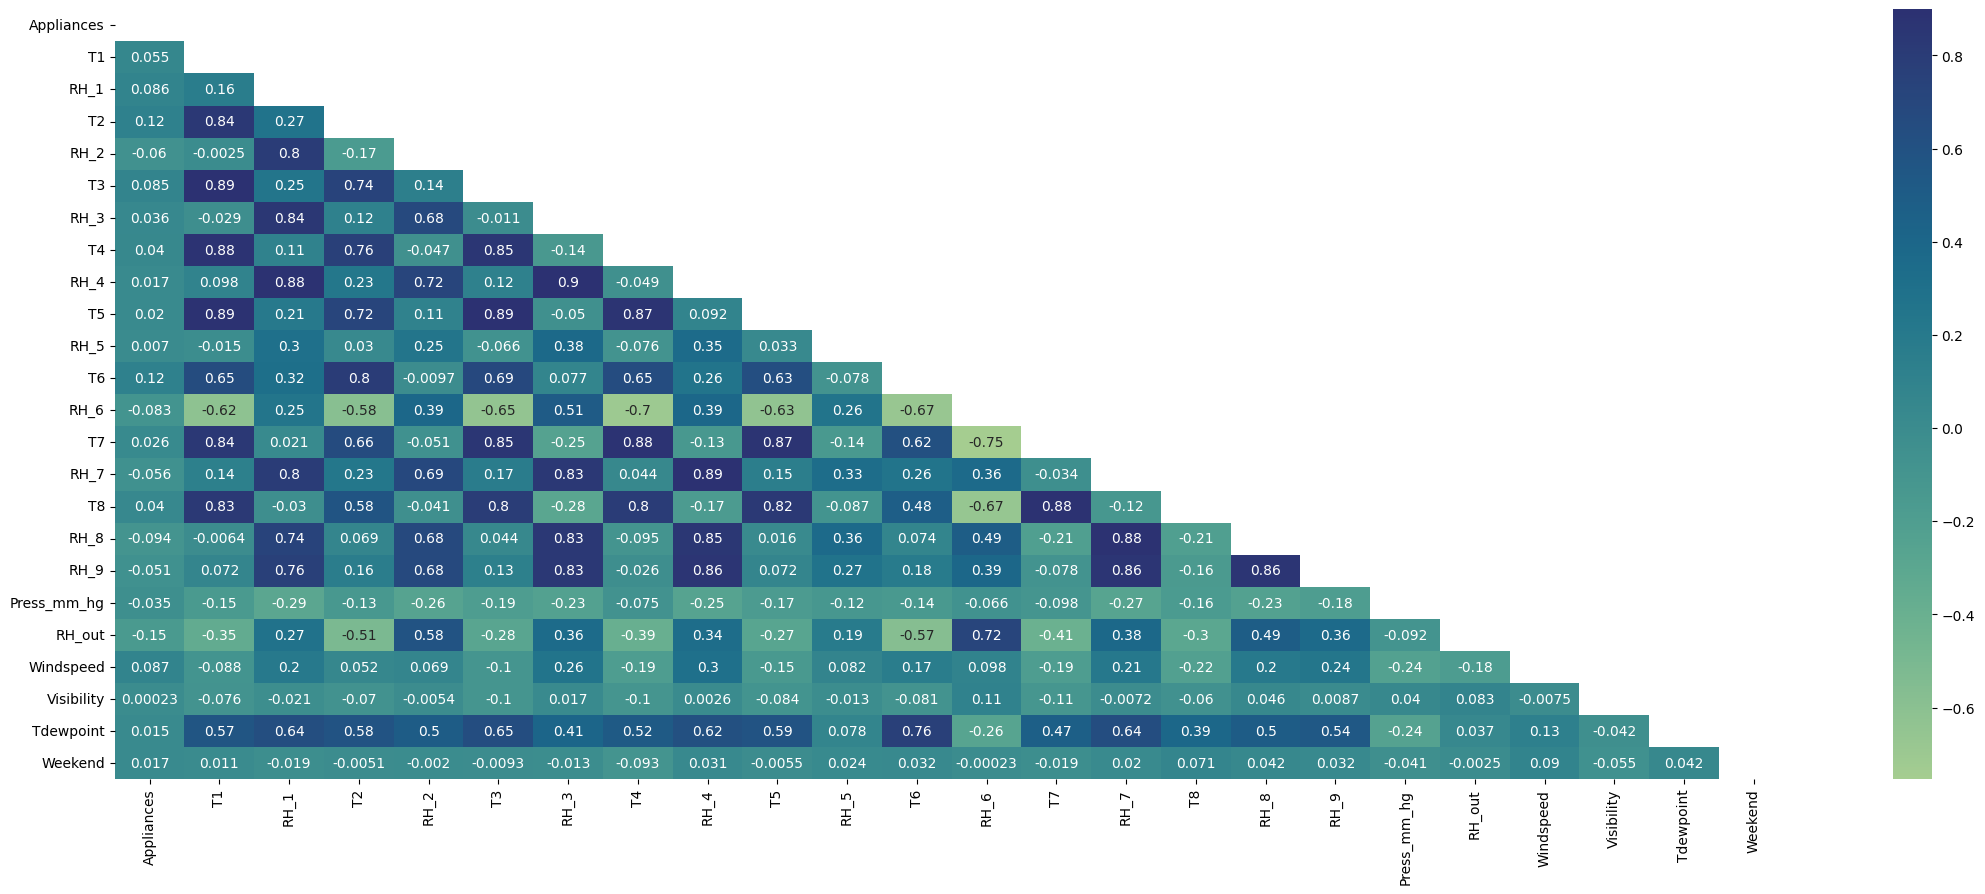

In [29]:
# Let's look at the correlation of the new column compared to the other features and the target:

plot_correlation(features_eng)

In [30]:
# Let's separate the target from the whole dataset:

target = df["Appliances"]
features_eng.drop(columns='Appliances', inplace=True)

#### 2.2) Transformation

In [31]:
# Function used to evaluate the best algorithms:

def melhor_modelo(X_train, y_train, dicionario):

    seed = 42
    cv = 5
    score = ['neg_root_mean_squared_error', 'r2']
    result_rmse = {}
    result_r2 = {}


    for name, model in dicionario.items():
        k_fold = KFold(n_splits=cv, random_state=seed, shuffle=True)
        result = cross_validate(model, X_train, y_train, cv=k_fold, scoring=score)

        result_rmse[name] = -result['test_neg_root_mean_squared_error']
        result_r2[name] = result['test_r2']
        
        
    result_pd_rmse = pd.DataFrame(data=result_rmse)
    result_pd_r2 = pd.DataFrame(data=result_r2)
    
    return result_pd_rmse, result_pd_r2
    

In [32]:
# Dictionary of algorithms:

modelos_dicionario = {
        "Lasso":Lasso(random_state=42),
        "Ridge":Ridge(random_state=42),
        "SVR":SVR(),
        "RandomForest":RandomForestRegressor(random_state=42),
        "XGB":XGBRegressor(random_state=42),
        "MLP":MLPRegressor(random_state=42, max_iter=2500)
    }

In [33]:
# Splitting into three sets: 

X_train, X_test, y_train, y_test = train_test_split(features_eng, target, test_size=0.25, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [34]:
# Printing shapes:

print("Shapes:")
print(f"X_Train set: {X_train.shape}")
print(f"y_Train set: {y_train.shape}\n")
print(f"X_Test set: {X_test.shape}")
print(f"y_Test set: {y_test.shape}")

Shapes:
X_Train set: (11840, 23)
y_Train set: (11840,)

X_Test set: (4934, 23)
y_Test set: (4934,)


In [35]:
# Numerical feature names:

numeric_columns = features_eng.drop(columns='Weekend').columns

##### 2.2.1) MinMaxScaler

In [36]:
# MinMax Scaler:

min_max_scaler = MinMaxScaler()
X_train_min_max = min_max_scaler.fit_transform(X_train[numeric_columns])
X_test_min_max = min_max_scaler.transform(X_test[numeric_columns])
X_val_min_max = min_max_scaler.transform(X_val[numeric_columns])


In [37]:
# Concatenating with the catgorical variable:

X_train_min_max = np.concatenate([X_train_min_max, X_train['Weekend'].values.reshape([-1, 1])], axis=1)
X_test_min_max = np.concatenate([X_test_min_max, X_test['Weekend'].values.reshape([-1, 1])], axis=1)
X_val_min_max = np.concatenate([X_val_min_max, X_val['Weekend'].values.reshape([-1, 1])], axis=1)

In [38]:
# Result of the function melhor_modelo:

resultados_min_max_rmse, resultados_min_max_r2 = melhor_modelo(X_train_min_max, y_train, modelos_dicionario)

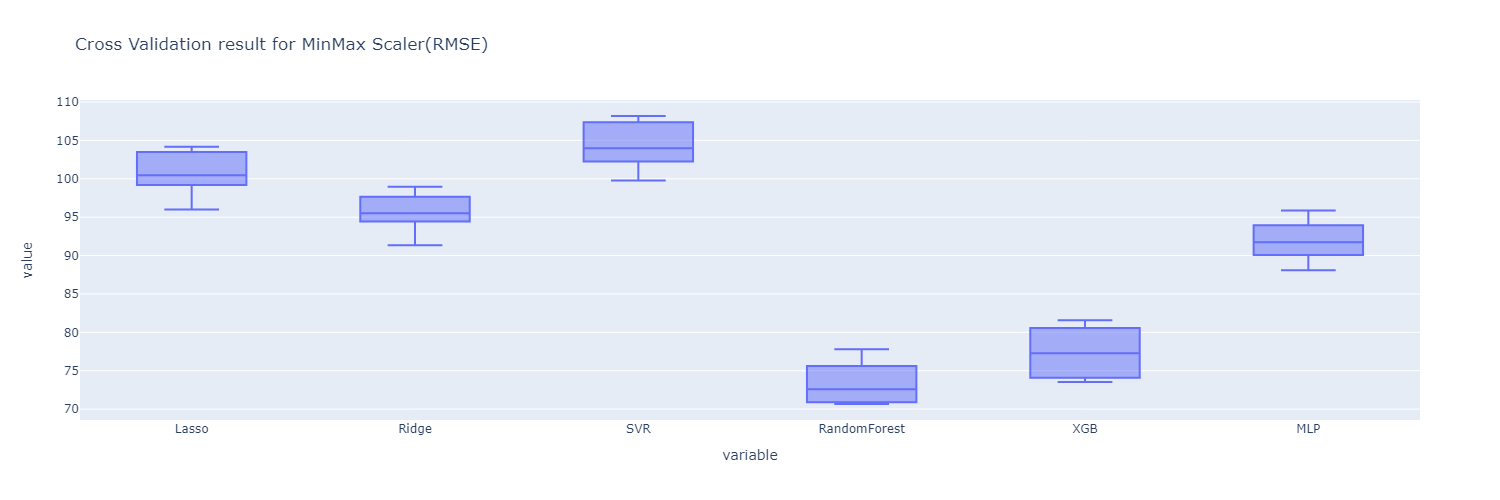

In [39]:
# Boxplot of the result for analisys of the algorithms, using MinMax Scaler:

fig = px.box(resultados_min_max_rmse, title= "Cross Validation result for MinMax Scaler(RMSE)")
fig.show("png",width=1500, height=500)

In [40]:
# Models statistics for RMSE metric, using MinMax Scaler:

resultados_min_max_rmse.describe()

,Lasso,Ridge,SVR,RandomForest,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,100.837602,95.711994,104.424783,73.376228,77.371759,91.948164
std,3.197019,2.835832,3.357458,2.990741,3.557050,2.899021
min,96.003991,91.339799,99.764463,70.661739,73.517098,88.094864
25%,100.264680,95.491181,103.068518,70.960053,74.248387,90.744802
50%,100.476851,95.521078,103.995333,72.567709,77.268679,91.718871
75%,103.257150,97.231169,107.113035,74.882754,80.235982,93.306994
max,104.185339,98.976742,108.182566,77.808885,81.588648,95.875286


In [41]:
# Models statistics for R2 metric, using MinMax Scaler: 

resultados_min_max_r2.describe()

,Lasso,Ridge,SVR,RandomForest,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.043090,0.137773,-0.026211,0.493114,0.436442,0.204248
std,0.002408,0.008998,0.008770,0.024174,0.030597,0.014683
min,0.039881,0.130925,-0.035205,0.457903,0.403957,0.186935
25%,0.042126,0.133481,-0.030565,0.482998,0.429182,0.196428
50%,0.042465,0.134827,-0.027314,0.498414,0.430557,0.198735
75%,0.045318,0.136139,-0.026134,0.504007,0.431323,0.218696
max,0.045662,0.153495,-0.011837,0.522246,0.487194,0.220445


Random Forest and XGBoost were the best algorithms while using the MinMax scaler.

##### 2.2.2) StandarScaler

In [42]:
# Standard Scaler:

std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train[numeric_columns])
X_test_std = std_scaler.transform(X_test[numeric_columns])
X_val_std = std_scaler.transform(X_val[numeric_columns])


In [43]:
# Concatenating with the catgorical variable:

X_train_std = np.concatenate([X_train_std, X_train['Weekend'].values.reshape([-1, 1])], axis=1)
X_test_std = np.concatenate([X_test_std, X_test['Weekend'].values.reshape([-1, 1])], axis=1)
X_val_std = np.concatenate([X_val_std, X_val['Weekend'].values.reshape([-1, 1])], axis=1)

In [44]:
# Result of the function melhor_modelo:

result_std_rmse, result_std_r2 = melhor_modelo(X_train_std, y_train, modelos_dicionario)

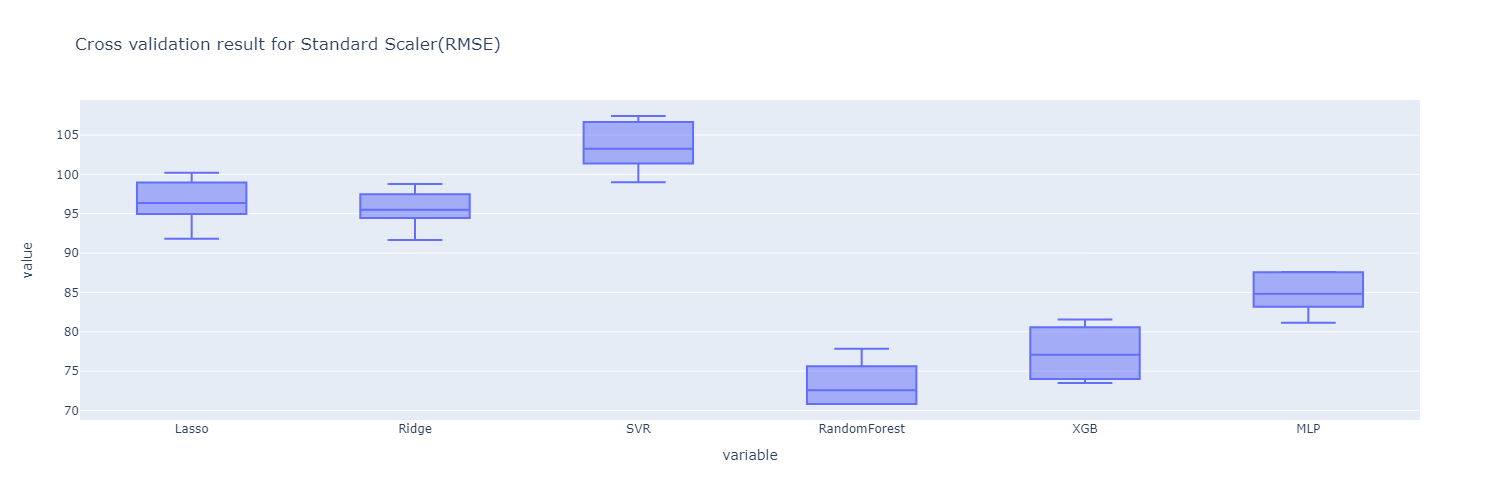

In [45]:
# Boxplot of the result for analisys of the algorithms, using Standard Scaler:

fig = px.box(result_std_rmse, title="Cross validation result for Standard Scaler(RMSE)")

fig.show('png', width=1500, height=500)

In [46]:
# Models statistics for RMSE metric, using Standard Scaler:

result_std_rmse.describe()

,Lasso,Ridge,SVR,RandomForest,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,96.597331,95.675782,103.656515,73.387465,77.315935,84.996150
std,3.171642,2.624177,3.384180,2.990603,3.581947,2.710201
min,91.818662,91.668324,98.990094,70.823709,73.476826,81.161167
25%,96.005999,95.397058,102.192842,70.844565,74.185456,83.844948
50%,96.372214,95.516012,103.270203,72.562054,77.093422,84.821524
75%,98.573740,97.033017,106.408814,74.860242,80.252429,87.554878
max,100.216038,98.764502,107.420621,77.846756,81.571544,87.598231


In [47]:
# Models statistics for R2 metric, using Standard Scaler: 

result_std_r2.describe()

,Lasso,Ridge,SVR,RandomForest,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.121905,0.138321,-0.011149,0.492914,0.437267,0.320102
std,0.007183,0.010732,0.009755,0.025268,0.030628,0.007802
min,0.111645,0.129914,-0.020675,0.457375,0.404206,0.313597
25%,0.118788,0.133181,-0.014628,0.480319,0.430149,0.314716
50%,0.122079,0.134377,-0.013850,0.498492,0.430323,0.317944
75%,0.127058,0.137193,-0.011874,0.504305,0.433900,0.321261
max,0.129957,0.156942,0.005283,0.524080,0.487755,0.332993


Random Fortest and XGBoost were the best algorithms while using the StandardScaler

##### 2.2.3) Robust Scaler

In [48]:
rb_scaler = RobustScaler()
X_train_rb =  rb_scaler.fit_transform(X_train[numeric_columns])
X_test_rb = rb_scaler.transform(X_test[numeric_columns])
X_val_rb = rb_scaler.transform(X_val[numeric_columns])

In [49]:
X_train_rb = np.concatenate([X_train_rb, X_train['Weekend'].values.reshape([-1, 1])], axis=1)
X_test_rb = np.concatenate([X_test_rb, X_test['Weekend'].values.reshape([-1, 1])], axis=1)
X_val_rb = np.concatenate([X_val_rb, X_val['Weekend'].values.reshape([-1, 1])], axis=1)

In [50]:
# Result of the function melhor_modelo:

result_rb_rmse,  result_rb_r2= melhor_modelo(X_train_rb, y_train, modelos_dicionario)

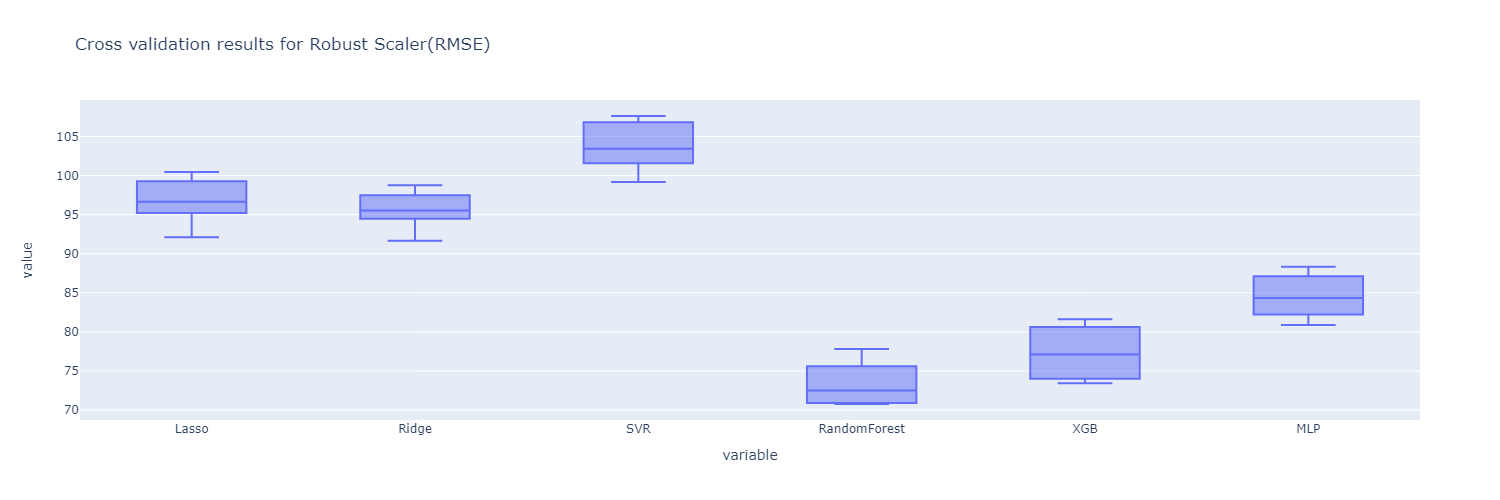

In [51]:
# Boxplot of the result for analisys of the algorithms, using Robust Scaler:

fig = px.box(result_rb_rmse, title="Cross validation results for Robust Scaler(RMSE)")
fig.show('png', width=1500, height=500)

In [52]:
# Models statistics for RMSE metric, using Rodbust Scaler:

result_rb_rmse.describe()

,Lasso,Ridge,SVR,RandomForest,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,96.867133,95.675196,103.836885,73.373902,77.322573,84.587257
std,3.154884,2.628590,3.382424,2.978834,3.612909,3.005824
min,92.118418,91.660295,99.179564,70.764037,73.427723,80.863071
25%,96.259313,95.397900,102.391338,70.940660,74.193128,82.688465
50%,96.639856,95.514215,103.419800,72.479130,77.093978,84.335711
75%,98.867735,97.035672,106.570529,74.871122,80.280180,86.703963
max,100.450341,98.767899,107.623196,77.814561,81.617858,88.345077


In [53]:
# Models statistics for R2 metric, using Rodbust Scaler:

result_rb_r2.describe()

,Lasso,Ridge,SVR,RandomForest,XGB,MLP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.116984,0.138334,-0.014674,0.493126,0.437164,0.326591
std,0.006699,0.010682,0.009693,0.024540,0.031122,0.018421
min,0.107486,0.130066,-0.024528,0.457824,0.403530,0.301151
25%,0.113887,0.133165,-0.018516,0.481500,0.429929,0.322543
50%,0.117440,0.134409,-0.016934,0.499638,0.430031,0.322945
75%,0.121349,0.137134,-0.014808,0.504161,0.433892,0.335049
max,0.124759,0.156896,0.001415,0.522507,0.488440,0.351266


Random Forest and XGBoost were the best algorithms while using the Robust Scaler

## 3) Tuning

As boxplot has shown before, the best algorithms were Random Forest and XGBoost for all of the transformations. So now, let's tune some Random Forest and XGBoost models, with all of the transformations, using a Bayesian Optimization.

In [54]:
# Function for tuning an arbitrary model:

def tuning(X_train, y_train, modelo, params):

    seed = 42
    cv = 5
  
    bayesian_op = BayesSearchCV(modelo, params, random_state=seed, cv=cv, 
                                scoring='neg_root_mean_squared_error', 
                                return_train_score=True,
                                n_iter=20,
                                n_jobs=-1
                                )
    
    
    bayesian_op.fit(X_train, y_train)

    best_index = bayesian_op.best_index_
    result = bayesian_op.cv_results_

    train_score = -result['mean_train_score'][best_index]
    test_score = -result['mean_test_score'][best_index]

    print(f"Train score: {train_score}")
    print(f"Left out data score: {test_score}")

    return bayesian_op.best_estimator_

In [55]:
# Parameter grid:

params_rnd = {'n_estimators':Integer(50, 1000),
              'max_depth':Integer(2, 200),
              'min_samples_split':Integer(2, 200),
              'min_samples_leaf':Integer(2, 200),
              'max_leaf_nodes':Integer(2, 200)
              }



params_xgb = {'n_estimators':Integer(50, 800),
              'max_depth':Integer(1, 4),
              'eta':Real(1e-4, 3e-1, 'log-uniform'),
              'alpha':Real(1e-2, 1e+3, 'log-uniform'),
              'gamma':Real(1e-2, 1e+3, 'log-uniform')
              }

3.1) MinMax Scaler

In [56]:
# Tuning a Random Forest using MinMax Scaler:

model_rnd = RandomForestRegressor(random_state=42)

print(f"Random Forest - MinMax Scaler:")
best_estimator_rnd_min_max = tuning(X_train_min_max, y_train, model_rnd, params_rnd)

Random Forest - MinMax Scaler:
Train score: 54.63010031187973
Left out data score: 80.89395139196117


In [57]:
# Tuning a XGBoost using MinMax Scaler:

model_xgb = XGBRegressor(random_state=42)

print("XGBoost - MinMax Scaler:")
best_estimator_xgb_min_max = tuning(X_train_min_max, y_train, model_xgb, params_xgb)

XGBoost - MinMax Scaler:
Train score: 39.044329941894475
Left out data score: 76.80625708191721


In [ ]:
# Tuning a Random Forest unsing Standard Scaler:

model_rnd = RandomForestRegressor(random_state=42)

print(f"Random Forest - Standard Scaler:")
best_estimator_rnd_std = tuning(X_train_std, y_train, model_rnd, params_rnd)

Random Forest - Standard Scaler:
Train score: 54.5861347795118
Left out data score: 81.26565768495728


In [ ]:
# Tuning a XGBoost using StandardScaler:

model_xgb = XGBRegressor(random_state=42)

print("XGBoost - Standard Scaler:")
best_estimator_xgb_std = tuning(X_train_std, y_train, model_xgb, params_xgb)

XGBoost - Standard Scaler:
Train score: 35.84698790878993
Left out data score: 77.4779578090976


3.3) Robust Scaler

In [ ]:
# Tuning a Random Forest using Robust Scaler:

model_rnd = RandomForestRegressor(random_state=42)

print(f"Random Forest - Robust Scaler:")
best_estimator_rnd_rb = tuning(X_train_rb, y_train, model_rnd, params_rnd)

Random Forest - Robust Scaler:
Train score: 69.35339305625429
Left out data score: 82.86923906947843


In [ ]:
# Tuning a XGBoost using Robust Scaler:

model_xgb = XGBRegressor(random_state=42)

print("XGBoost - Robust Scaler:")
best_estimator_xgb_rb = tuning(X_train_rb, y_train, model_xgb, params_xgb)

XGBoost - Robust Scaler:
Train score: 35.49480509900191
Left out data score: 77.82571872156184


Conclusions

 - Random Forest didn't seem to suffer from Overvitting.

 - XGBoost apparently is suffering from Overfitting.

 - XGBoost, using MinMax Scaler, had the best results on the Left Out data.

## 4) Predictions

First, let's try to retrain it without an early stopping method.

In [ ]:
# Retraining an XGBoost model using MinMax Scaler:

xgb_params_min_max = clone(best_estimator_xgb_min_max)

In [ ]:
# Training a XGBoost model:

xgb_params_min_max.fit(X_train_min_max, y_train)

XGBRegressor(alpha=291.08888601755547, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.13012186149129515,
             eval_metric=None, feature_types=None, gamma=0.01, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=800, n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Predicting train set and test set:

y_pred_train = xgb_params_min_max.predict(X_train_min_max)
y_pred_test = xgb_params_min_max.predict(X_test_min_max)


# Calculating metrics for train set:

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

# Calculating metrics for test set:

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

In [ ]:
# Train set results:

print("Train results:")
print(f"RMSE: {rmse_train}")
print(f"R2 score: {r2_train}")

Train results:
RMSE: 38.92414145800809
R2 score: 0.8575502515024612


In [ ]:
# Test set results:

print("Test results:")
print(f"RMSE: {rmse_test}")
print(f"R2 score: {r2_test}")

Test results:
RMSE: 71.85813586102495
R2 score: 0.4802029235261488


Using Early Stopping

In [ ]:
# Retraining an XGBoost model using MinMax Scaler:

xgb_params_min_max = clone(best_estimator_xgb_min_max)


# Setting early stopping parameters:

xgb_params_min_max.eval_metric = "rmse"
xgb_params_min_max.early_stopping_rounds = 10

In [ ]:
# Training a XGBoost model:

xgb_params_min_max.fit(X_train_min_max, y_train, eval_set=[(X_train_min_max, y_train), (X_val_min_max, y_val)], verbose=True)

[0]	validation_0-rmse:132.70006	validation_1-rmse:132.99414
[1]	validation_0-rmse:124.78168	validation_1-rmse:125.61761
[2]	validation_0-rmse:118.39978	validation_1-rmse:119.60451
[3]	validation_0-rmse:112.98568	validation_1-rmse:114.68178
[4]	validation_0-rmse:108.82935	validation_1-rmse:110.83909
[5]	validation_0-rmse:105.38921	validation_1-rmse:107.84204
[6]	validation_0-rmse:102.48326	validation_1-rmse:105.18589
[7]	validation_0-rmse:100.03736	validation_1-rmse:103.17363
[8]	validation_0-rmse:98.12415	validation_1-rmse:101.48485
[9]	validation_0-rmse:96.34929	validation_1-rmse:100.00584
[10]	validation_0-rmse:95.21963	validation_1-rmse:99.14390
[11]	validation_0-rmse:94.10314	validation_1-rmse:98.37429
[12]	validation_0-rmse:93.11126	validation_1-rmse:97.68206
[13]	validation_0-rmse:92.06915	validation_1-rmse:96.86788
[14]	validation_0-rmse:91.48907	validation_1-rmse:96.48505
[15]	validation_0-rmse:90.71250	validation_1-rmse:95.89882
[16]	validation_0-rmse:90.27032	validation_1-rms

XGBRegressor(alpha=291.08888601755547, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eta=0.13012186149129515,
             eval_metric='rmse', feature_types=None, gamma=0.01, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=800, n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Predicting train set and test set:

y_pred_train = xgb_params_min_max.predict(X_train_min_max)
y_pred_test = xgb_params_min_max.predict(X_test_min_max)


# Calculating metrics for train set:

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

# Calculating metrics for test set:

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

In [ ]:
# Train set results:

print("Train results:")
print(f"RMSE: {rmse_train}")
print(f"R2 score: {r2_train}")

Train results:
RMSE: 53.37453073526841
R2 score: 0.7321499437329468


In [ ]:
# Test set results:

print("Test results:")
print(f"RMSE: {rmse_test}")
print(f"R2 score: {r2_test}")

Test results:
RMSE: 75.41990031006249
R2 score: 0.4273966989021012
